<a href="https://colab.research.google.com/github/vkvinay0627/NYC-Taxi-Trip-Time-Prediction---Capstone-Project/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# **Libraries**

In [3]:
import pandas as pd
import numpy as np
from numpy import *
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud
from scipy import signal
from matplotlib import *
from pandas import DataFrame
import os
from pandas import DataFrame
from ipywidgets import interact, interactive, fixed, interact_manual 
plt.style.use('fivethirtyeight')
import datetime as dt
import pandas as pd
import os
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact, IntSlider, interactive, widgets, interact_manual,HBox,fixed
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Almabetter/NYC Taxi Data.csv',encoding='latin1',low_memory=False)


# **Data Laoding**

In [6]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
# duplicate
len(df[df.duplicated()])

0

In [8]:
df.trip_duration.value_counts(ascending=True)

8522        1
6419        1
83884       1
83256       1
85305       1
         ... 
358      1577
367      1581
348      1582
408      1584
368      1624
Name: trip_duration, Length: 7417, dtype: int64

In [9]:
#Check for NaN values
print(df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


There is no NaN/NULL record in the dataset, So we dont have to impute any record.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [12]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(df.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [13]:
#Convert timestamp to datetime format to fetch the other details as listed below
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [14]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
df['weekday'] = df['pickup_datetime'].dt.day_name()
df['month'] = df['pickup_datetime'].dt.month
df['month_name'] = df['pickup_datetime'].dt.month_name()
df['weekday_num'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,month_name,weekday_num,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,3,March,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,June,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,January,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,4,April,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,3,March,5,13


In [15]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km



In [16]:
    df['distance'] = haversine_np(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

In [17]:
#Calculate Speed in km/h for further insights
df['speed'] = (df.distance/(df.trip_duration/3600))

In [18]:
#Check the type of each variable
df.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [19]:
pd.options.display.float_format = '{:.3f}'.format #To suppres scientific notation.
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,month_name,weekday_num,pickup_hour,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,Monday,3,March,0,17,1.498,11.849
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,Sunday,6,June,6,0,1.804,9.798
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,Tuesday,1,January,1,11,6.381,10.815
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,Wednesday,4,April,2,19,1.485,12.458
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,Saturday,3,March,5,13,1.188,9.830


# **Data Cleaning And EDA**

**Trip Duration**

****





In [20]:
df.trip_duration.describe()

count   1458644.000
mean        959.492
std        5237.432
min           1.000
25%         397.000
50%         662.000
75%        1075.000
max     3526282.000
Name: trip_duration, dtype: float64

In [21]:
df.trip_duration.sort_values(ascending=False).head(5)

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
Name: trip_duration, dtype: int64

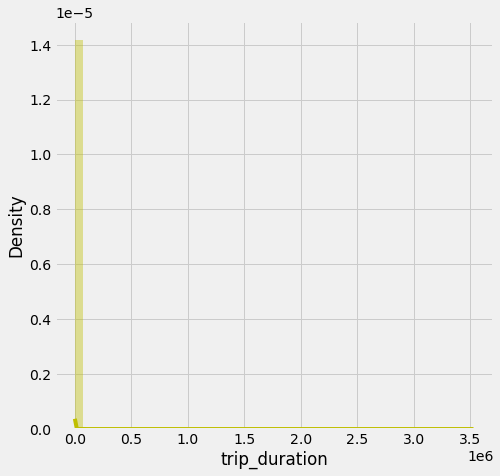

In [22]:
# Dependent variable 'Price'
plt.figure(figsize=(7,7))
sns.distplot(df['trip_duration'],color="y")

In [23]:
#### Lets compute the Interquantile range to calculate the boundaries
IQR=df.trip_duration.quantile(0.75)-df.trip_duration.quantile(0.25)
IQR
#### Extreme outliers
upper_bridge=df['trip_duration'].quantile(0.75)+(IQR*3)
print(upper_bridge)
df = df[df.trip_duration <= upper_bridge]
len(df)

3109.0


1437680

In [24]:
df.trip_duration.sort_values(ascending=False).head(5)

1017349    3109
945931     3109
1246915    3109
433860     3109
1258483    3109
Name: trip_duration, dtype: int64

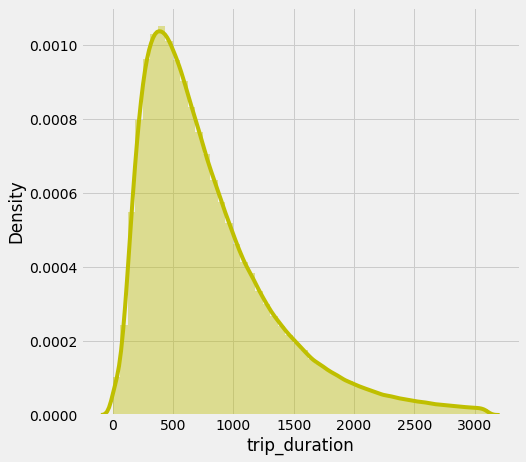

In [25]:
plt.figure(figsize=(7,7))
sns.distplot(df['trip_duration'],color="y")

Trip_duration is slightly skewed to the right. Therefore log transformation

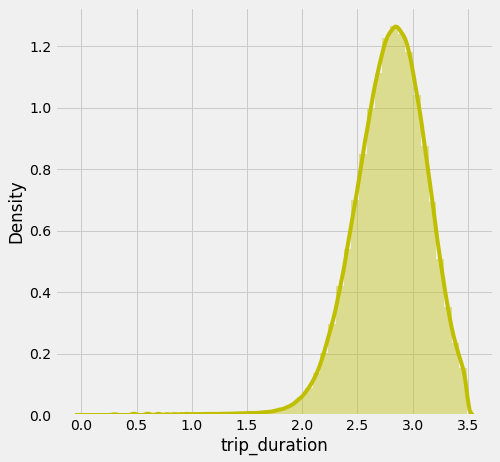

In [26]:

plt.figure(figsize=(7,7))
sns.distplot(np.log10(df['trip_duration']),color="y")

**Distance**

count   1437680.000
mean          3.258
std           3.911
min           0.000
25%           1.222
50%           2.065
75%           3.759
max        1240.130
Name: distance, dtype: float64


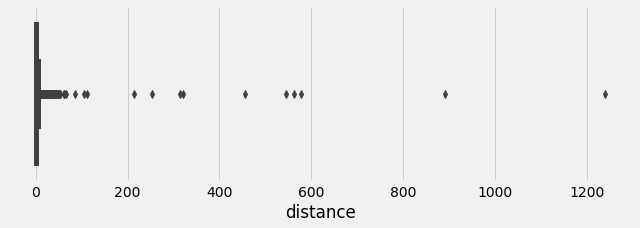

In [27]:

print(df.distance.describe())
plt.figure(figsize = (10,3))
sns.boxplot(df.distance)
plt.show()

In [28]:
df.distance.value_counts()

0.000     5866
0.000      114
0.000       54
0.001       46
0.001       41
          ... 
4.404        1
1.735        1
10.472       1
2.672        1
1.289        1
Name: distance, Length: 1431356, dtype: int64

In [29]:
print("Number of trips with distance 0 are {}".format(df.distance[df.distance == 0].count()))

Number of trips with distance 0 are 5866


In [30]:
df['distance'] = np.where(df.distance<=1,1,df.distance)
df.distance.min()

1.0

Weekday


In [31]:
for feature in df.columns[:]:
    print(feature,":",len(df[feature].unique()),'labels')

id : 1437680 labels
vendor_id : 2 labels
pickup_datetime : 1361395 labels
dropoff_datetime : 1361680 labels
passenger_count : 10 labels
pickup_longitude : 22661 labels
pickup_latitude : 44891 labels
dropoff_longitude : 32957 labels
dropoff_latitude : 61510 labels
store_and_fwd_flag : 2 labels
trip_duration : 3109 labels
weekday : 7 labels
month : 6 labels
month_name : 6 labels
weekday_num : 7 labels
pickup_hour : 24 labels
distance : 1191976 labels
speed : 1431652 labels


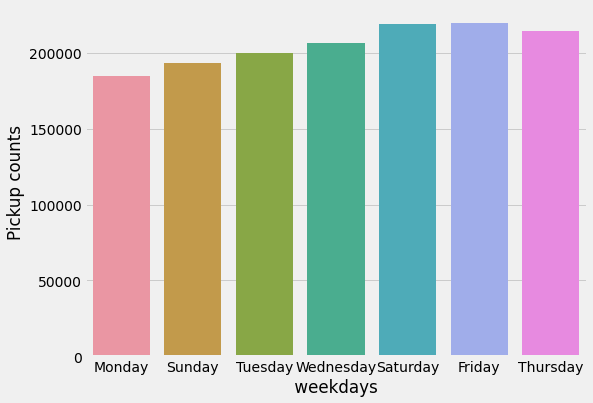

In [32]:
plt.figure(figsize = (8,6))
sns.countplot(df.weekday)
plt.xlabel(' weekdays ')
plt.ylabel('Pickup counts')
plt.show()

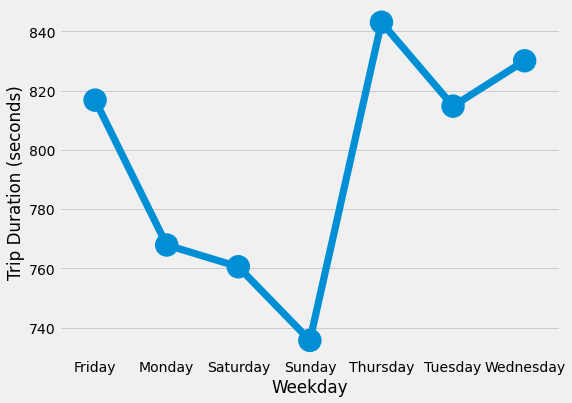

In [33]:
plt.figure(figsize = (8,6))
group2 = df.groupby('weekday').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

In [34]:
week_day_count = df['weekday'].value_counts().head(7)
print(week_day_count)


Friday       219652
Saturday     219170
Thursday     214453
Wednesday    206556
Tuesday      199819
Sunday       193329
Monday       184701
Name: weekday, dtype: int64


In [35]:

dictionary={'Monday':1,'Tuesday':1,'Wednesday':2,'Thursday':2,'Friday':2,'Saturday':2,'Sunday':1 }
df['weekday_ordinal']=df['weekday'].map(dictionary)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,month_name,weekday_num,pickup_hour,distance,speed,weekday_ordinal
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,Monday,3,March,0,17,1.498,11.849,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,Sunday,6,June,6,0,1.804,9.798,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,Tuesday,1,January,1,11,6.381,10.815,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,Wednesday,4,April,2,19,1.485,12.458,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,Saturday,3,March,5,13,1.188,9.830,2


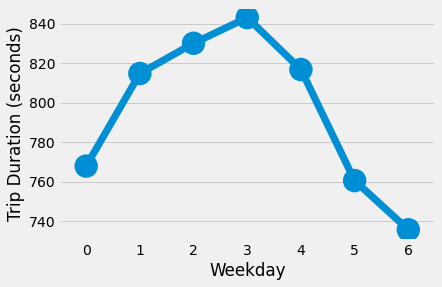

In [36]:
group2 = df.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

In [37]:
# df['weekday'] = np.where(df.weekday.isin(['Monday','Tuesday','Sunday']) ,1,0)
# df22 = df.loc(df['weekday'] ==1)

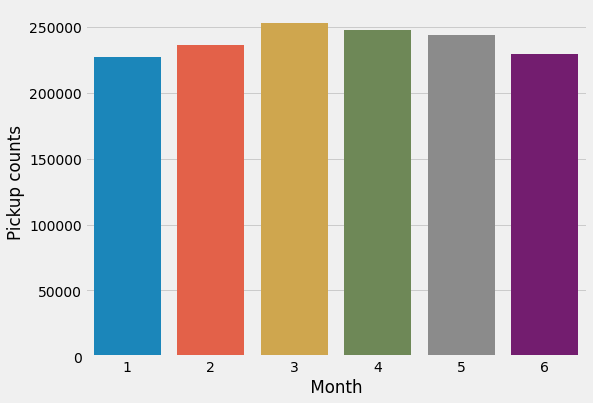

In [38]:
plt.figure(figsize = (8,6))
sns.countplot(df.month)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

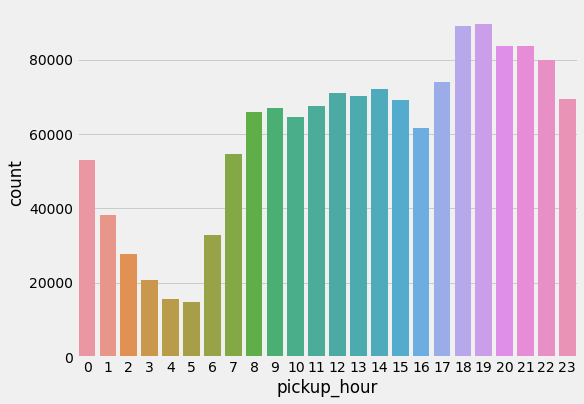

In [39]:
plt.figure(figsize = (8,6))
sns.countplot(df.pickup_hour)
plt.show()

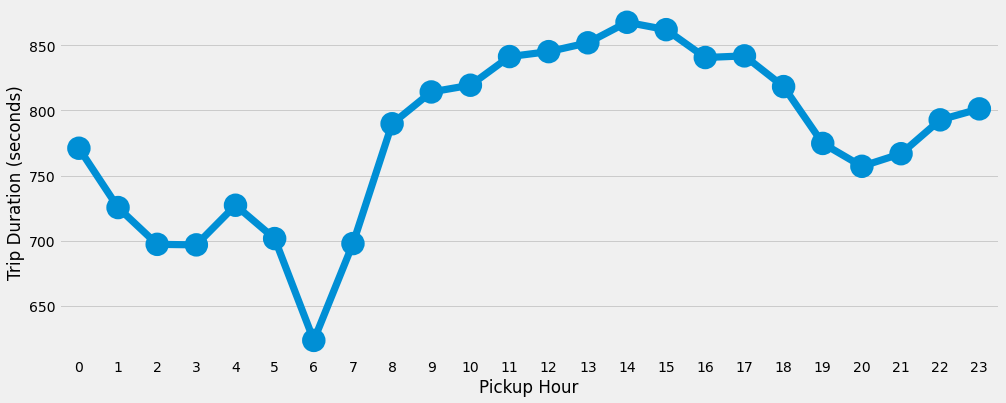

In [40]:
plt.figure(figsize = (15,6))
group1 = df.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

In [41]:


from pandas import DataFrame
pick_up_count =df['pickup_hour'].value_counts()
pick_up_count = DataFrame(pick_up_count)
pick_up_count.reset_index(level=0, inplace=True)
pick_up_count.columns = ['Weekdays', 'Weekdays_Count']
high_freq_days = pick_up_count.loc[pick_up_count.Weekdays_Count > 60000]
low_freq_days =  pick_up_count.loc[pick_up_count.Weekdays_Count < 60000]
print(low_freq_days)

    Weekdays  Weekdays_Count
16         7           54626
17         0           53003
18         1           38339
19         6           32744
20         2           27872
21         3           20814
22         4           15725
23         5           14935


In [42]:
dictionary={19:2,18:2,21:2,20:2,22 :2,17 :2,14 :2,12: 2,13 :2,23 :2,15 :2,11 :2,9 :2, 8 :2,10 :2,16 :2
             ,7: 1,0: 1,1: 1,6: 1,2: 1,3: 1,4: 1,5: 1
}
df['pickup_hour_ordinal']=df['pickup_hour'].map(dictionary)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,month_name,weekday_num,pickup_hour,distance,speed,weekday_ordinal,pickup_hour_ordinal
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,Monday,3,March,0,17,1.498,11.849,1,2
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,Sunday,6,June,6,0,1.804,9.798,1,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,Tuesday,1,January,1,11,6.381,10.815,1,2
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,Wednesday,4,April,2,19,1.485,12.458,2,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,Saturday,3,March,5,13,1.188,9.830,2,2


In [43]:
numeric_features = df.iloc[:,[4,10,12,14,16,17,18,19]]
numeric_features.head()
# numeric_features[:].head()

,passenger_count,trip_duration,month,weekday_num,distance,speed,weekday_ordinal,pickup_hour_ordinal
0,1,455,3,0,1.498,11.849,1,2
1,1,663,6,6,1.804,9.798,1,1
2,1,2124,1,1,6.381,10.815,1,2
3,1,429,4,2,1.485,12.458,2,2
4,1,435,3,5,1.188,9.830,2,2


**Passenger**

In [44]:
df.passenger_count.value_counts()

1    1019897
2     206532
5      76873
3      58930
6      47563
4      27822
0         58
7          3
9          1
8          1
Name: passenger_count, dtype: int64

**Observations:**

1.   There are 0 passengers in some records.
2.   Data even consisted of 7,8 or 9 passengers,which can be considered as outliers


In [45]:
df.passenger_count.describe()

count   1437680.000
mean          1.663
std           1.313
min           0.000
25%           1.000
50%           1.000
75%           2.000
max           9.000
Name: passenger_count, dtype: float64

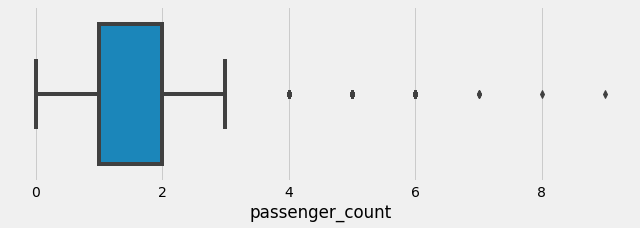

In [46]:
plt.figure(figsize = (10,3))
sns.boxplot(df.passenger_count)
plt.show()



1.   Trip is not possible without passengers. As per above details. Mean median and mode are all approx equal to 1. So we would replace the 0 passenger count with 1.
2.   We would also remove records with passenger count > 6.



In [47]:
df['passenger_count'] = df.passenger_count.map(lambda x: 1 if x == 0 else x)
df = df[df.passenger_count <= 6 ]
len(df)

1437675

In [48]:
df.passenger_count.value_counts()

1    1019955
2     206532
5      76873
3      58930
6      47563
4      27822
Name: passenger_count, dtype: int64

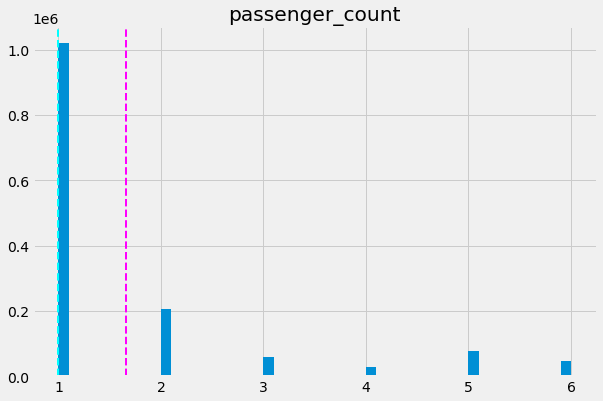

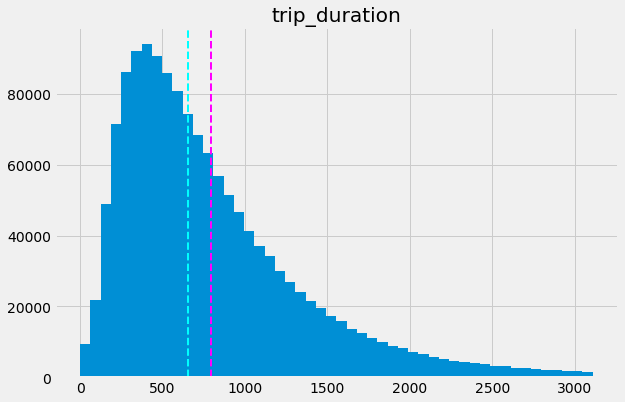

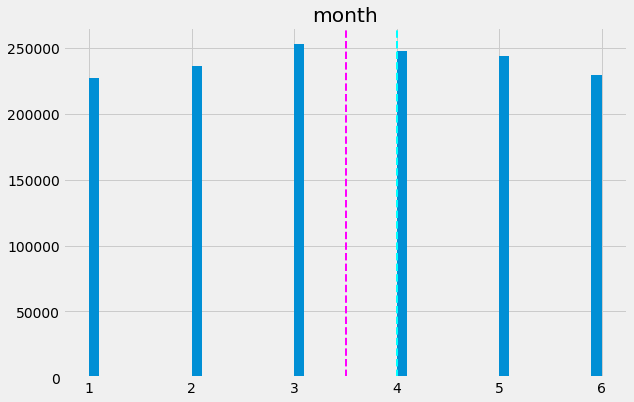

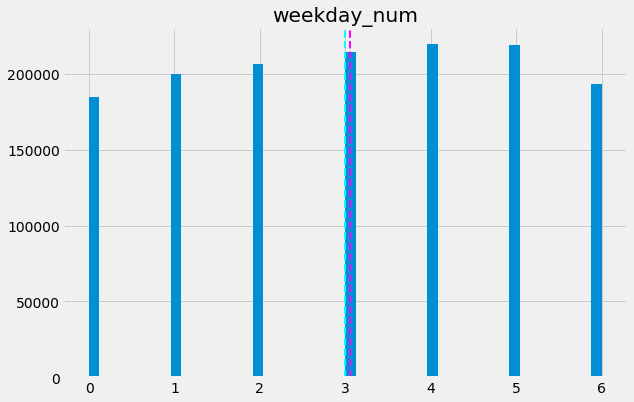

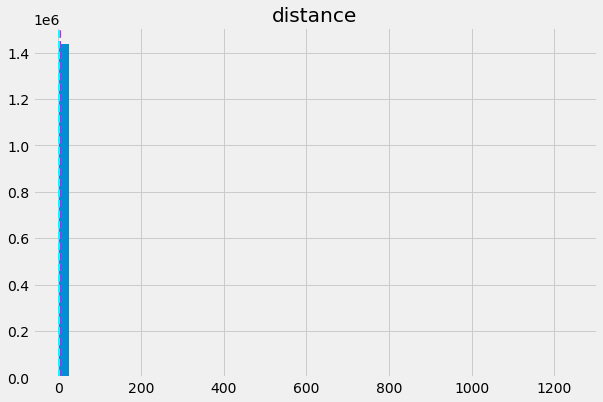

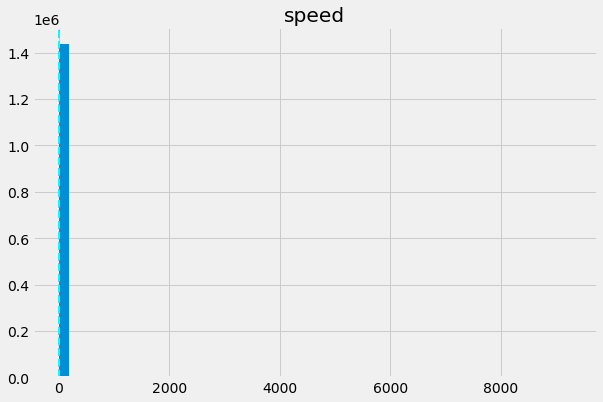

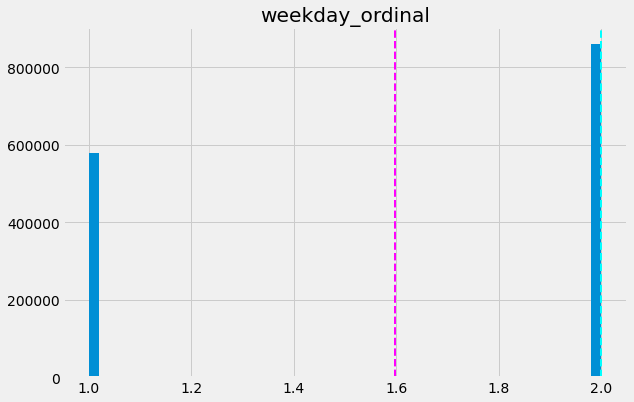

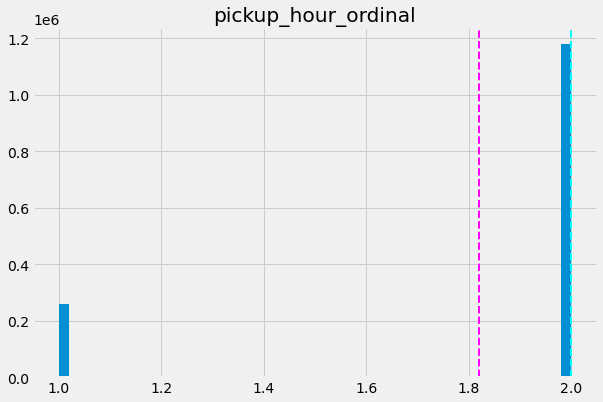

In [49]:
#@title Default title text
# plot a bar plot for each numerical feature count (except car_ID)

for col in numeric_features[:]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

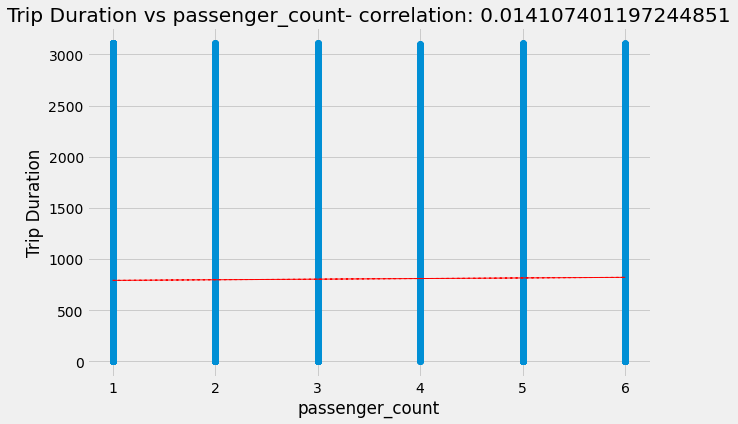

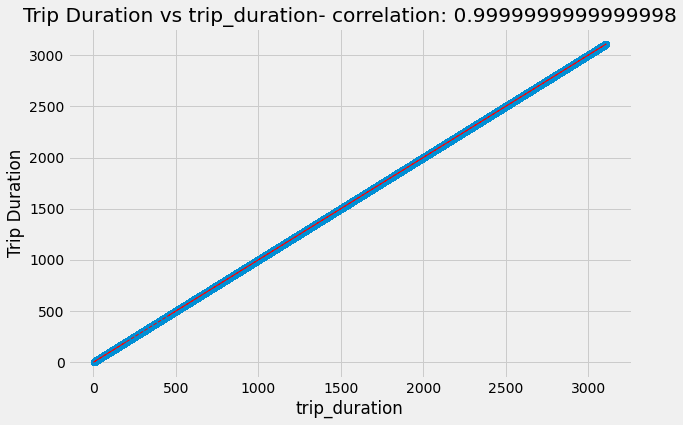

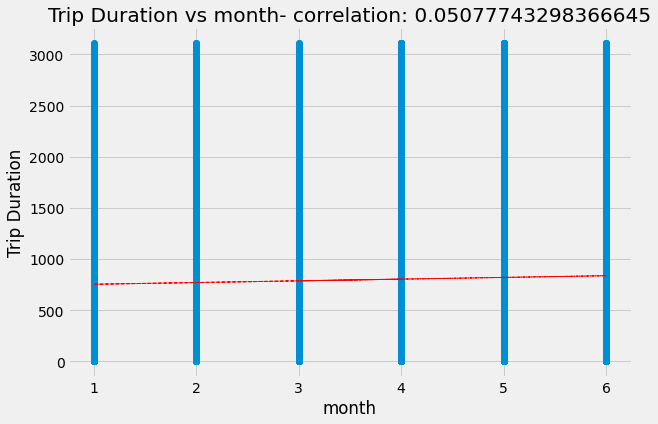

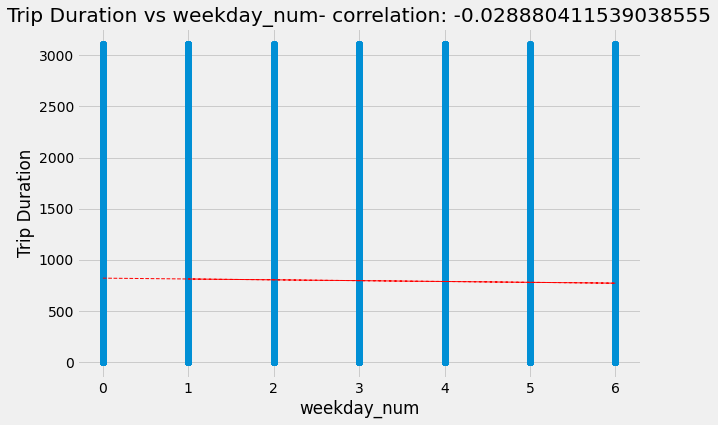

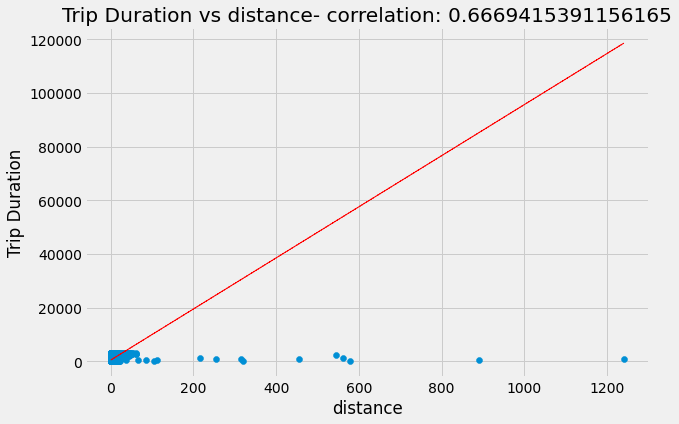

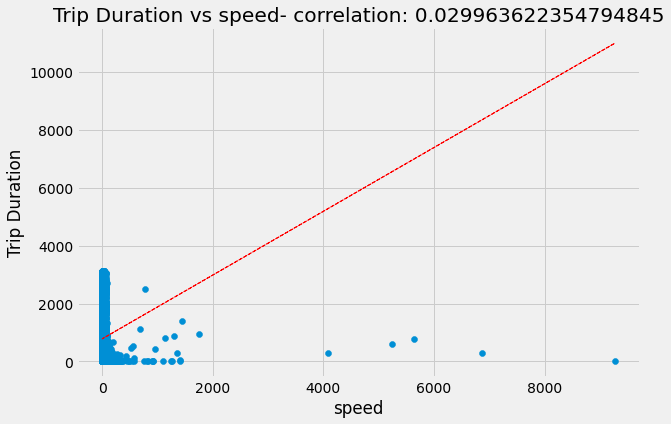

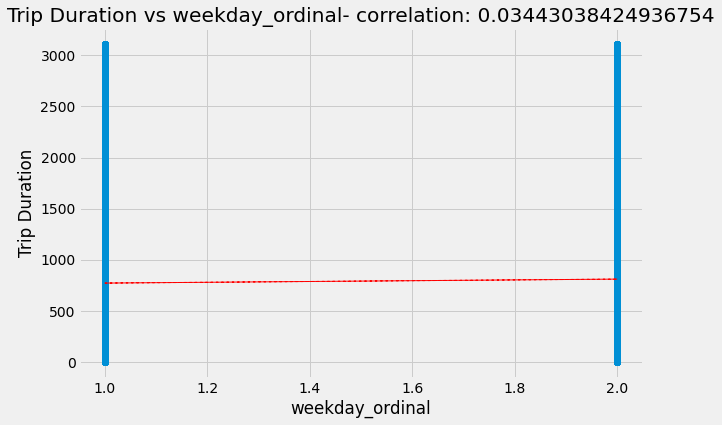

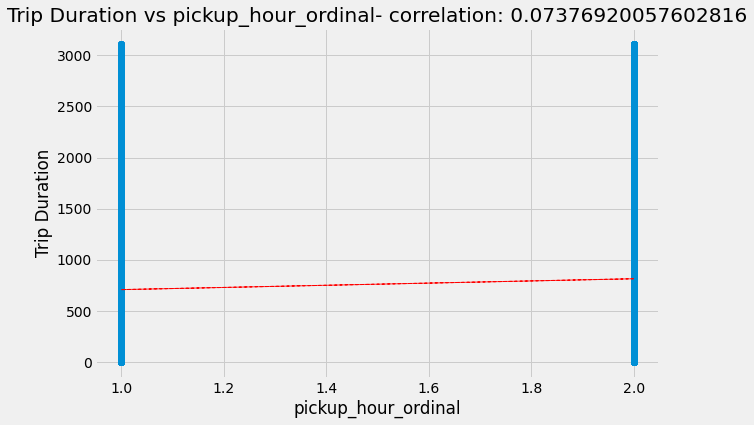

In [50]:
for col in numeric_features[:]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip Duration')
    ax.set_title('Trip Duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(df[col], df['trip_duration'], 1)
    y_hat = np.poly1d(z)(df[col])

    plt.plot(df[col], y_hat, "r--", lw=1)

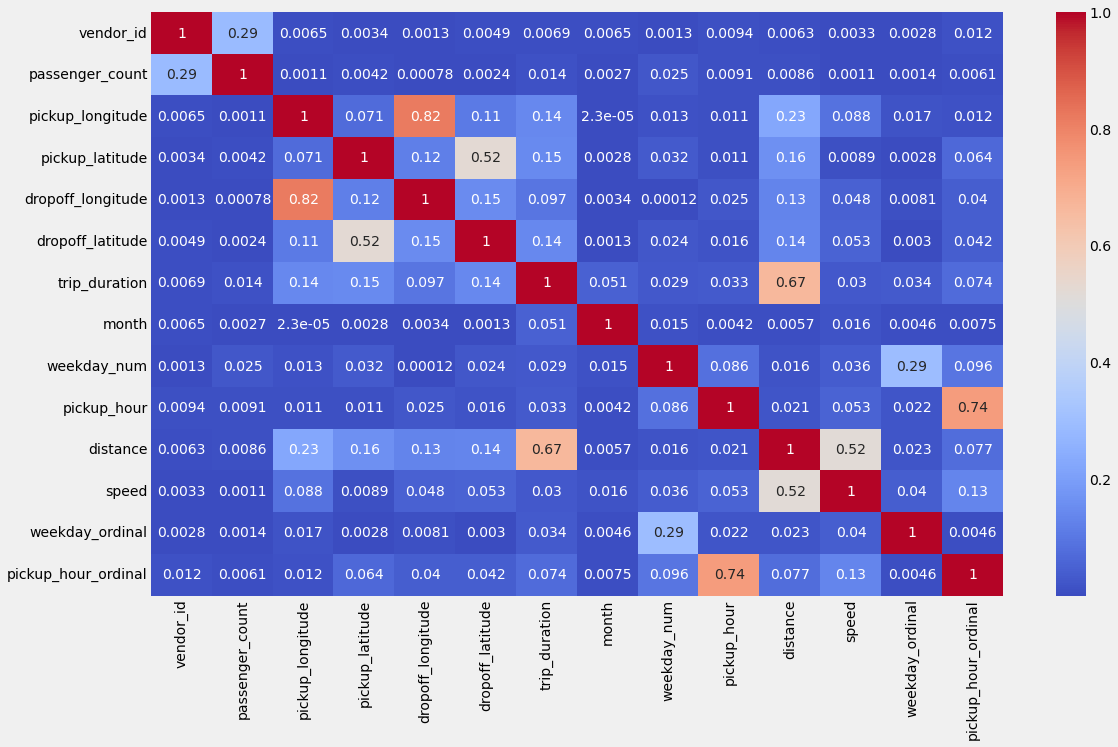

In [51]:
 ## Correlation
plt.figure(figsize=(17,10))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

1. Pickup_hour_ordinal co-relates with pickup_hour. Delete pickup_hour before modeling
2.  Distance is co-related with speed. Drop the speed column

In [52]:
correlation.trip_duration

vendor_id              0.007
passenger_count        0.014
pickup_longitude       0.141
pickup_latitude       -0.148
dropoff_longitude      0.097
dropoff_latitude      -0.141
trip_duration          1.000
month                  0.051
weekday_num           -0.029
pickup_hour            0.033
distance               0.667
speed                  0.030
weekday_ordinal        0.034
pickup_hour_ordinal    0.074
Name: trip_duration, dtype: float64

In [53]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,month_name,weekday_num,pickup_hour,distance,speed,weekday_ordinal,pickup_hour_ordinal
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,Monday,3,March,0,17,1.498,11.849,1,2
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,Sunday,6,June,6,0,1.804,9.798,1,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,Tuesday,1,January,1,11,6.381,10.815,1,2
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,Wednesday,4,April,2,19,1.485,12.458,2,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,Saturday,3,March,5,13,1.188,9.830,2,2


In [54]:
features_f = df.iloc[:,[4,12,14,16,17,18,19]]
features_f.head()
features =features_f.copy()
features

,passenger_count,month,weekday_num,distance,speed,weekday_ordinal,pickup_hour_ordinal
0,1,3,0,1.498,11.849,1,2
1,1,6,6,1.804,9.798,1,1
2,1,1,1,6.381,10.815,1,2
3,1,4,2,1.485,12.458,2,2
4,1,3,5,1.188,9.830,2,2
...,...,...,...,...,...,...,...
1458639,4,4,4,1.224,5.665,2,2
1458640,1,1,6,6.046,33.230,1,1
1458641,1,4,4,7.820,36.847,2,1
1458642,1,1,1,1.092,10.538,1,2


In [57]:
from scipy.stats import zscore
X = features.apply(zscore)
X

,passenger_count,month,weekday_num,distance,speed,weekday_ordinal,pickup_hour_ordinal
0,-0.505,-0.304,-1.561,-0.468,-0.170,-1.220,0.468
1,-0.505,1.481,1.506,-0.389,-0.307,-1.220,-2.138
2,-0.505,-1.494,-1.050,0.792,-0.239,-1.220,0.468
3,-0.505,0.291,-0.539,-0.472,-0.130,0.820,0.468
4,-0.505,-0.304,0.995,-0.548,-0.305,0.820,0.468
...,...,...,...,...,...,...,...
1458639,1.779,0.291,0.484,-0.539,-0.582,0.820,0.468
1458640,-0.505,-1.494,1.506,0.705,1.251,-1.220,-2.138
1458641,-0.505,0.291,0.484,1.163,1.492,0.820,-2.138
1458642,-0.505,-1.494,-1.050,-0.573,-0.258,-1.220,0.468


In [58]:
y = np.log10(df['trip_duration'])
y

0         2.658
1         2.822
2         3.327
3         2.632
4         2.638
           ... 
1458639   2.891
1458640   2.816
1458641   2.883
1458642   2.572
1458643   2.297
Name: trip_duration, Length: 1437675, dtype: float64

In [59]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(1150140, 7)
(287535, 7)


In [60]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.5068366673920137

In [61]:
print(reg.coef_)
print(len(reg.coef_))
print(reg.intercept_)

[ 0.0031633   0.00813102 -0.00626791  0.29529863 -0.23548186  0.01064828
  0.01568221]
7
2.7940791638977847


In [62]:
y_pred = reg.predict(X_test)
y_pred

array([2.57591918, 2.69824368, 2.71797754, ..., 2.81095323, 2.81488758,
       2.8667793 ])

In [63]:
from sklearn.metrics import mean_squared_error

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 263534244932.4796
RMSE : 513355.8657817008


In [64]:
from sklearn.metrics import r2_score
r2 = r2_score(10**(y_test), 10**(y_pred))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

R2 : -865978.6123902703
Adjusted R2 :  -865999.6951313233


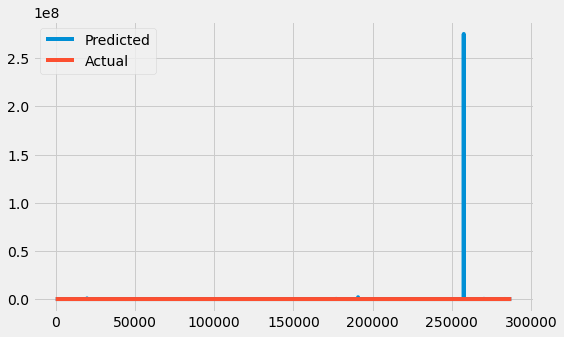

In [65]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred))
plt.plot(np.array(10**(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

In [66]:
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha=0.0001 , max_iter= 3000)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [67]:
lasso.score(X_train, y_train)

0.5068356096405142

In [68]:
### Cross validation
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [69]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.0001}

Using  {'alpha': 0.0001}  the negative mean squared error is:  -0.053524683775770646


In [70]:
y_pred_lasso = lasso_regressor.predict(X_test)

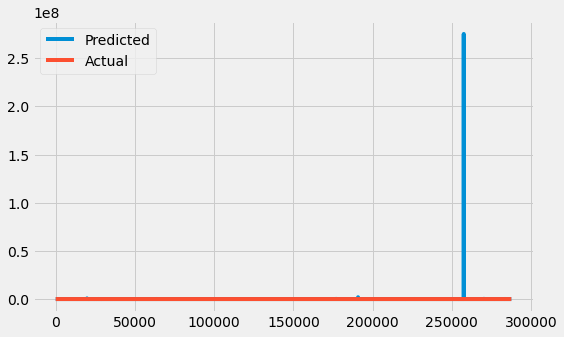

In [71]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_lasso))
plt.plot(10**(np.array(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

In [72]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_lasso))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_lasso))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_lasso)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 263634162720.00284
RMSE : 513453.17480759905
R2 : -866306.9445466184
Adjusted R2 :  -866328.035281095


In [73]:
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [74]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 100}

Using  {'alpha': 100}  the negative mean squared error is:  -0.05349683660019414


In [75]:
y_pred_ridge = ridge_regressor.predict(X_test)

In [76]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 263689234172.35022
RMSE : 513506.80051227193
R2 : -866487.9106103259
Adjusted R2 :  -866509.0057505189


In [77]:
from sklearn.linear_model import ElasticNet
#a * L1 + b * L2
#alpha = a + b and l1_ratio = a / (a + b)
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [78]:
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [79]:
elasticnet.score(X_train, y_train)

0.3204095305619101

In [80]:
y_pred_en = elasticnet.predict(X_test)

In [81]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_en))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_en))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_en)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 951191376413.8059
RMSE : 975290.406193871
R2 : -3125635.820622077
Adjusted R2 :  -3125711.9159374544


In [82]:
elastic = ElasticNet()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100],'l1_ratio':[0.3,0.4,0.5,0.6,0.7,0.8]}
elastic_regressor = GridSearchCV(elastic, parameters, scoring='neg_mean_squared_error',cv=5)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100],
                         'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [83]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.0001, 'l1_ratio': 0.4}

Using  {'alpha': 0.0001, 'l1_ratio': 0.4}  the negative mean squared error is:  -0.053524660590885564


In [84]:
y_pred_elastic = elastic_regressor.predict(X_test)

In [85]:
MSE  = mean_squared_error(10**(y_test), 10**(y_pred_elastic))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score(10**(y_test), 10**(y_pred_elastic))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score(10**(y_test), 10**(y_pred_elastic)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 263680770549.31384
RMSE : 513498.5594422966
R2 : -866460.0989496504
Adjusted R2 :  -866481.1934127536


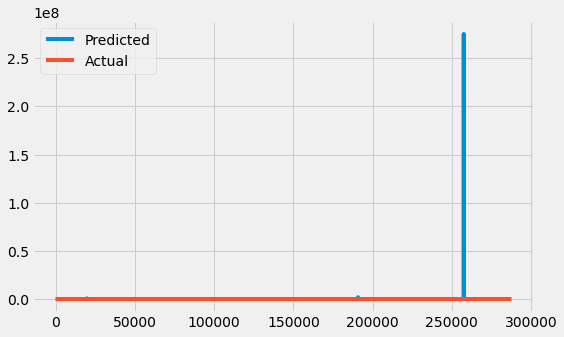

In [86]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_elastic))
plt.plot(10**(np.array(y_test)))
plt.legend(["Predicted","Actual"])
plt.show()